In [1]:
# standard library
from pathlib import Path

# 3rd party
import pandas as pd

# aind
from lamf_analysis.code_ocean.code_ocean_data_explorer import CodeOceanDataExplorer 
#from ophys_mfish_dev.code_ocean.data_asset_loader import DataAssetLoader
import lamf_analysis.utils as utils

# my repo
import mdev.utils.lims_utils as lu
aws_mnt = Path('/mnt') # define folder where buckets are mounted locally


## AWS mounting notes
+ make sure aind-ophys-bucket is mounted
+ buckets found for multiplane data assets
    + aind-ophys-data
    + aind-private-data-prod-o5171v
    + aind-scratch-data (not used)

## Notes on data assets found 
+ 1 found in the stratch bucket, so I filter that out
+ 27 empty datasets

In [2]:
def raw_asset_list_to_df(asset_list):
    for asset in asset_list:
        bucket = asset['source_bucket']['bucket']
        mount_folder = asset['mount']
        session_path = aws_mnt / bucket / mount_folder

        # ophsy folder, can be wither [ophys, pophys, mpophys], check for all
        ophys_folder = utils.check_ophys_folder(session_path)

        # if asset has mesoscope json, then no need for file splitting pipeline
        meso_string = "MESOSCOPE_FILE_SPLITTING_QUEUE*"
        meso_files = list(ophys_folder.glob(meso_string))
        need_fs = len(meso_files) < 1

        platform_file = list(ophys_folder.glob('*platform.json'))[0]

        lims_osid = int(platform_file.name.split('_')[0])
        mount_info_dict = {'session_path': session_path,
                        'ophys_path': ophys_folder,
                        'platform_json_path': platform_file,
                        'lims_osid': lims_osid,
                        'need_filesplitting': need_fs}
        
        asset.update(mount_info_dict)

    df = pd.DataFrame(asset_list)
    drops_cols = ['created', 'custom_metadata', 'description', 'last_used', 'mount', 'size', 'source_bucket','tags','type', 'files','state', 'tags']
    df = df.drop(columns=drops_cols)

    return df


def derived_asset_list_to_df(asset_list):

    df = pd.DataFrame(asset_list)
    drops_cols = ['created', 'custom_metadata', 'description', 'last_used', 'mount', 'size','type', 'files','state']
    df = df.drop(columns=drops_cols)

    df = df.rename(columns={'name':'processed_name'})
    df = df.rename(columns={'id':'processed_id'})
    df['processed_type'] = df['processed_name'].apply(lambda x: x.split('_')[4])

    df['pipeline'] = df['tags'].apply(lambda x: [tag for tag in x if 'pipeline' in tag])
    df = df.drop(columns=['tags'])
    df['pipeline'] = df['pipeline'].apply(lambda x: x[0] if len(x) > 0 else None)
    df['prefix_name'] = df['processed_name'].apply(lambda x: '_'.join(x.split('_')[:4]))
    return df


def remove_empty_mount_folders(asset_list):
    """Some empy data folders in AWS, remove them"""
    mounted_assets = []
    not_mounted_assets = []
    for asset in asset_list:

        bucket = asset['source_bucket']['bucket']
        mount_folder = asset['mount']
        session_path = aws_mnt / bucket / mount_folder


        if not session_path.exists():
            not_mounted_assets.append(asset)
            continue
        else:
            mounted_assets.append(asset)

    return mounted_assets, not_mounted_assets

In [3]:
# 0. Make sure ENV variables are set correctly. You should add them to your bashrc file or equivalent

os.environ["CODEOCEAN_DOMAIN"] = "https://codeocean.allenneuraldynamics.org/"
os.environ["CODEOCEAN_TOKEN"] = "cop_ZDcyZjY4MDBhMGNmNDVkNGI1MjdjZTI5ODVkODU3YWJlWmhxSVV5bDR4dWxDTTVoUXJqZGF6OWViUVJXMmwxMmYyMTdmZDhj"

In [4]:
# 1. Use CODE to get assets on code ocean 
code = CodeOceanDataExplorer(query='multiplane')
ra = code.raw_assets
da = code.derived_assets
ra = [a for a in ra if a['source_bucket']['bucket'] != "aind-scratch-data"] # only 1 found in scratch
print(len(ra))
print(len(da))

CodeOceanDataExplorer initialized
---------------------------------
Query: multiplane
Number of assets: 799
539
176


In [5]:
# 2. get clean raw and derived tables

# make raw table
raw_assets, empty_assets = remove_empty_mount_folders(ra)
print(f"n_raw_assets: {len(raw_assets)}, n_empty_assets: {len(empty_assets)} dropped")

raw_table = raw_asset_list_to_df(raw_assets)
len_rt = len(raw_table)
raw_table = raw_table.drop_duplicates(subset=['name'], keep='first')
print("n_raw_assets: ", len(raw_table))
print(f"dropped {len_rt - len(raw_table)} duplicates")


# make derived table
derived_table = derived_asset_list_to_df(da)
derived_table = derived_table[derived_table['processed_type'] == 'processed'].copy() # remove dlc-eye
len_dt = len(derived_table)
derived_table = derived_table.drop_duplicates(subset=['prefix_name'], keep='first')
print(f"dropped {len_dt - len(derived_table)} duplicates")
print("n_derived_assets: ", len(derived_table))
derived_table.head()

# only keep processed_type = 'processed'


n_raw_assets: 512, n_empty_assets: 27 dropped
n_raw_assets:  338
dropped 174 duplicates
dropped 26 duplicates
n_derived_assets:  139


,processed_id,processed_name,provenance,source_bucket,processed_type,pipeline,prefix_name
0,971c436e-617c-432f-8f55-c31830091583,multiplane-ophys_726433_2024-05-14_08-13-15_pr...,{'capsule': 'cd3897a2-bc35-4d9a-9bf2-d86fd9c85...,NaN,processed,pipeline-v4.0,multiplane-ophys_726433_2024-05-14_08-13-15
1,c9257f7c-2306-47a3-9bc6-1258ab761084,multiplane-ophys_729088_2024-06-10_09-47-15_pr...,{'capsule': 'cd3897a2-bc35-4d9a-9bf2-d86fd9c85...,NaN,processed,pipeline-v4.0,multiplane-ophys_729088_2024-06-10_09-47-15
2,3133e6bb-4ed1-4a5c-a668-42eb0773c9aa,multiplane-ophys_729088_2024-06-07_08-58-13_pr...,{'capsule': 'cd3897a2-bc35-4d9a-9bf2-d86fd9c85...,NaN,processed,pipeline-v4.0,multiplane-ophys_729088_2024-06-07_08-58-13
3,76af66f0-5186-48c1-8195-5067d51ec16b,multiplane-ophys_724567_2024-05-20_12-00-33_pr...,{'capsule': 'cd3897a2-bc35-4d9a-9bf2-d86fd9c85...,NaN,processed,pipeline-v4.0,multiplane-ophys_724567_2024-05-20_12-00-33
4,df354ee2-e612-494d-aa46-ee9400be9bc7,multiplane-ophys_687001_2023-11-02_09-10-38_pr...,{'capsule': 'cd3897a2-bc35-4d9a-9bf2-d86fd9c85...,NaN,processed,pipeline-v4.0,multiplane-ophys_687001_2023-11-02_09-10-38


In [8]:
raw_table

,id,name,session_path,ophys_path,platform_json_path,lims_osid,need_filesplitting
0,4b9d1b3d-dd71-46f1-aeec-03ea64c41700,multiplane-ophys_724567_2024-05-20_12-00-21,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1367710111,True
1,2778b9f1-127a-4c2b-87c5-ea2ec8139a75,multiplane-ophys_687001_2023-10-05_11-26-08,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1301716302,False
2,941dfb69-46cb-4bc0-aed5-67ed2219a45b,multiplane-ophys_693996_2023-10-30_09-10-18,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1307507669,False
3,f7332a09-19a2-4ffe-b051-4f65ff4d3dad,multiplane-ophys_693996_2023-10-20_08-45-31,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1305037814,False
4,e298efce-c3dc-4926-bc0f-6b92bbc096a3,multiplane-ophys_726433_2024-05-29_10-48-25,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1369518919,False
...,...,...,...,...,...,...,...
506,61b9fcd8-4c8b-41a4-a623-f3bee9ccbbb1,multiplane-ophys_677594_2023-08-03_09-56-38,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,1287475236,False
507,e19b2223-c8e0-4a57-aeeb-39e81f67ae37,multiplane-ophys_677594_2023-07-28_09-29-23,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,1286031935,False
508,9f7e16c0-516e-442e-8042-b9738e7b16ed,multiplane-ophys_677594_2023-07-27_10-19-00,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,/mnt/aind-ophys-data/multiplane-ophys_677594_2...,1285830771,False
509,5d448339-9518-4320-8815-92a895da47a7,multiplane-ophys_686385_2023-09-26_15-33-50,/mnt/aind-ophys-data/multiplane-ophys_686385_2...,/mnt/aind-ophys-data/multiplane-ophys_686385_2...,/mnt/aind-ophys-data/multiplane-ophys_686385_2...,1299751969,False


In [16]:
# 3. Get session table from LIMS
session_table = lu.aind_projects_sessions_table(simple=True, lamf_only=True)
session_table.head()
print(f"n sessions: {len(session_table)}")

n sessions: 743


In [12]:
merge_df = raw_table.merge(session_table, left_on='lims_osid', right_on='ophys_session_id', how='left')

print("n_assets: ", len(merge_df))
merge_df.head()

n_assets:  338


,id,name,session_path,ophys_path,platform_json_path,lims_osid,need_filesplitting,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code
0,4b9d1b3d-dd71-46f1-aeec-03ea64c41700,multiplane-ophys_724567_2024-05-20_12-00-21,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1367710111,True,1.367710e+09,724567,1.343636e+09,2024-05-20,OPHYS_2_images_A_passive,MESO.1,LearningmFISHDevelopment
1,2778b9f1-127a-4c2b-87c5-ea2ec8139a75,multiplane-ophys_687001_2023-10-05_11-26-08,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1301716302,False,1.301716e+09,687001,1.285649e+09,2023-10-05,STAGE_1,MESO.2,LearningmFISHDevelopment
2,941dfb69-46cb-4bc0-aed5-67ed2219a45b,multiplane-ophys_693996_2023-10-30_09-10-18,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1307507669,False,1.307508e+09,693996,1.294309e+09,2023-10-30,STAGE_1,MESO.1,LearningmFISHDevelopment
3,f7332a09-19a2-4ffe-b051-4f65ff4d3dad,multiplane-ophys_693996_2023-10-20_08-45-31,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1305037814,False,1.305038e+09,693996,1.294309e+09,2023-10-20,STAGE_1,MESO.1,LearningmFISHDevelopment
4,e298efce-c3dc-4926-bc0f-6b92bbc096a3,multiplane-ophys_726433_2024-05-29_10-48-25,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1369518919,False,1.369519e+09,726433,1.341432e+09,2024-05-29,STAGE_1,MESO.2,LearningmFISHDevelopment


In [13]:
# count by project_code
merge_df['project_code'].value_counts()

LearningmFISHDevelopment    112
LearningmFISHTask1A          78
Name: project_code, dtype: int64

In [17]:
# merge with derived
final_df = merge_df.merge(derived_table, left_on='name', right_on='prefix_name', how='left')
print("n_assets: ", len(final_df))

n_assets:  338


In [18]:
final_df[final_df.duplicated(subset='name', keep=False)]

,id,name,session_path,ophys_path,platform_json_path,lims_osid,need_filesplitting,ophys_session_id,mouse_id,specimen_id,...,session_type,equipment_name,project_code,processed_id,processed_name,provenance,source_bucket,processed_type,pipeline,prefix_name


## lims to co table

In [27]:
# merge raw
lims_co_table = session_table.merge(raw_table, right_on='lims_osid', left_on='ophys_session_id', how='left')
# merge derived
lims_co_table = lims_co_table.merge(derived_table, left_on='name', right_on='prefix_name', how='left')

# annotate bool cols

# 'is_raw' if name not nan
lims_co_table['is_raw'] = lims_co_table['name'].notnull()
lims_co_table['is_ophys_processed'] = lims_co_table['processed_type'] == 'processed'
lims_co_table['is_eye_processed'] = lims_co_table['processed_type'] == 'dlc-eye'

# sort by [mouse_id, date_str] descending
lims_co_table = lims_co_table.sort_values(by=['project_code','mouse_id', 'date_str'], ascending=False).reset_index(drop=True)


# split table by project_code
project_codes = lims_co_table['project_code'].unique()
project_tables = {}
for project_code in project_codes:
    project_tables[project_code] = lims_co_table[lims_co_table['project_code'] == project_code].reset_index(drop=True)

lims_co_table


,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code,id,name,session_path,...,processed_id,processed_name,provenance,source_bucket,processed_type,pipeline,prefix_name,is_raw,is_ophys_processed,is_eye_processed
0,1376299088,729417,1345480316,2024-06-27,TRAINING_0_gratings_autorewards_15min,MESO.2,LearningmFISHTask1A,e343cbda-ad52-4fef-8221-927b6b551040,multiplane-ophys_729417_2024-06-27_10-49-11,/mnt/aind-private-data-prod-o5171v/multiplane-...,...,e2bc5e3d-6385-4a45-9114-909a8e2efb0a,multiplane-ophys_729417_2024-06-27_10-49-11_pr...,{'capsule': '56bf687b-dbcd-4b93-a650-21b858403...,NaN,processed,None,multiplane-ophys_729417_2024-06-27_10-49-11,True,True,False
1,1371158930,729417,1345480316,2024-06-06,TRAINING_1_gratings,MESO.1,LearningmFISHTask1A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2,1370656359,729417,1345480316,2024-06-04,TRAINING_1_gratings,MESO.1,LearningmFISHTask1A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,1370446273,729417,1345480316,2024-06-03,TRAINING_1_gratings,MESO.1,LearningmFISHTask1A,c4d14957-c0fb-47c8-8f21-141e9a68c70c,multiplane-ophys_729417_2024-06-03_09-27-38,/mnt/aind-private-data-prod-o5171v/multiplane-...,...,20e4c466-bed7-4e67-b39a-4ebc7e379259,multiplane-ophys_729417_2024-06-03_09-27-38_pr...,NaN,NaN,processed,None,multiplane-ophys_729417_2024-06-03_09-27-38,True,True,False
4,1369914629,729417,1345480316,2024-05-31,TRAINING_1_gratings,MESO.1,LearningmFISHTask1A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1131473286,582466,1111394840,2021-09-29,OPHYS_1_images_A,MESO.2,LearningmFISHDevelopment,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
764,1105808212,565950,1085087236,2021-05-27,OPHYS_2_images_A_passive,MESO.2,LearningmFISHDevelopment,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
765,1105557066,565950,1085087236,2021-05-26,OPHYS_1_images_A,MESO.2,LearningmFISHDevelopment,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
766,1105296431,565950,1085087236,2021-05-25,OPHYS_1_images_A,MESO.2,LearningmFISHDevelopment,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [29]:
import seaborn as sns
# get first 5 of LearningmFISHDevelopment	
project_code = 'LearningmFISHDevelopment'
project_table = project_tables[project_code]

def process_track_table_display(project_table):
    plot_cols = ['mouse_id','ophys_session_id','session_type','date_str','is_raw', 'is_ophys_processed', 'is_eye_processed']
    pretty_table = project_table[plot_cols].copy()
    pretty_table = pretty_table.fillna('None')
    pretty_table = pretty_table.style.applymap(lambda x: 'background-color: green' if x == True else '')
    return pretty_table

pretty_table = process_track_table_display(project_tables['LearningmFISHDevelopment'])
pretty_table

,mouse_id,ophys_session_id,session_type,date_str,is_raw,is_ophys_processed,is_eye_processed
0,730933,1370949854,OPHYS_2_images_A_passive,2024-06-05,False,False,False
1,730929,1374600699,STAGE_1,2024-06-20,True,False,False
2,730929,1373231491,STAGE_1,2024-06-14,False,False,False
3,730929,1371209490,OPHYS_2_images_A_passive,2024-06-06,False,False,False
4,729088,1372240290,STAGE_1,2024-06-11,False,False,False
5,729088,1371955818,OPHYS_2_images_A_passive,2024-06-10,True,True,False
6,729088,1371363286,OPHYS_2_images_A_passive,2024-06-07,True,True,False
7,729088,1370911904,OPHYS_2_images_A_passive,2024-06-05,False,False,False
8,729088,1370668802,STAGE_1,2024-06-04,False,False,False
9,729088,1370454229,STAGE_1,2024-06-03,True,False,False


In [30]:
pretty_table = process_track_table_display(project_tables['LearningmFISHTask1A'])
pretty_table

,mouse_id,ophys_session_id,session_type,date_str,is_raw,is_ophys_processed,is_eye_processed
0,729417,1376299088,TRAINING_0_gratings_autorewards_15min,2024-06-27,True,True,False
1,729417,1371158930,TRAINING_1_gratings,2024-06-06,False,False,False
2,729417,1370656359,TRAINING_1_gratings,2024-06-04,False,False,False
3,729417,1370446273,TRAINING_1_gratings,2024-06-03,True,True,False
4,729417,1369914629,TRAINING_1_gratings,2024-05-31,False,False,False
5,729417,1369716955,TRAINING_1_gratings,2024-05-30,False,False,False
6,729417,1369499806,TRAINING_1_gratings,2024-05-29,True,True,False
7,729417,1369304451,TRAINING_1_gratings,2024-05-28,False,False,False
8,729417,1368306892,TRAINING_1_gratings,2024-05-23,True,True,False
9,729417,1368080408,TRAINING_0_gratings_autorewards_15min,2024-05-22,True,True,False


# Oi4 - Jun 6 2024

In [9]:
oi4_mice = ['726433', '724567', '729088'] # snap, 32, 32

# filter for oi4 mice
oi4_df = final_df[final_df['mouse_id'].isin(oi4_mice)]
oi4_df

,id,name,session_path,ophys_path,platform_json_path,lims_osid,need_filesplitting,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code,processed_id,processed_name,provenance,processed_type,pipeline,prefix_name
0,fc1cdfec-f058-412d-9ec6-8d511427ee7b,multiplane-ophys_724567_2024-05-20_12-00-21,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1367710111,True,1.367710e+09,724567,1.343636e+09,2024-05-20,OPHYS_2_images_A_passive,MESO.1,LearningmFISHDevelopment,91cc4000-7a02-486a-aa74-86db4619f525,multiplane-ophys_724567_2024-05-20_12-00-21_pr...,NaN,processed,None,multiplane-ophys_724567_2024-05-20_12-00-21
6,5833ef57-4c70-4358-8d56-e3ca4da59bac,multiplane-ophys_724567_2024-05-17_10-34-03,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1367144679,True,1.367145e+09,724567,1.343636e+09,2024-05-17,OPHYS_2_images_A_passive,MESO.1,LearningmFISHDevelopment,8e58cac0-61e4-43a6-a6ea-c866352afa71,multiplane-ophys_724567_2024-05-17_10-34-03_pr...,{'capsule': '56bf687b-dbcd-4b93-a650-21b858403...,processed,None,multiplane-ophys_724567_2024-05-17_10-34-03
21,944aa90d-575a-474c-8169-81648adfd9da,multiplane-ophys_724567_2024-05-16_11-04-17,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1366935465,True,1.366935e+09,724567,1.343636e+09,2024-05-16,STAGE_1,MESO.1,LearningmFISHDevelopment,a664c46b-5baa-4b66-ae2a-10ef77a61204,multiplane-ophys_724567_2024-05-16_11-04-17_pr...,{'capsule': '56bf687b-dbcd-4b93-a650-21b858403...,processed,None,multiplane-ophys_724567_2024-05-16_11-04-17
22,350148c1-ccfc-4e9c-96a8-e43b8a3a2fc9,multiplane-ophys_726433_2024-05-14_08-13-02,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1366394411,True,1.366394e+09,726433,1.341432e+09,2024-05-14,OPHYS_2_images_A_passive,MESO.1,LearningmFISHDevelopment,NaN,NaN,NaN,NaN,NaN,NaN
39,ef8d91d8-8283-440b-9fd3-63a69295e141,multiplane-ophys_726433_2024-05-17_08-27-42,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,/mnt/aind-private-data-prod-o5171v/multiplane-...,1367127502,True,1.367128e+09,726433,1.341432e+09,2024-05-17,OPHYS_2_images_A_passive,MESO.1,LearningmFISHDevelopment,37f3c75d-36e0-46cb-a486-7da9945140e9,multiplane-ophys_726433_2024-05-17_08-27-42_pr...,{'capsule': '56bf687b-dbcd-4b93-a650-21b858403...,processed,None,multiplane-ophys_726433_2024-05-17_08-27-42


In [28]:
# add ids to list
oi4_ids = oi4_df['id'].to_list()
oi4_ids

['fc1cdfec-f058-412d-9ec6-8d511427ee7b',
 '5833ef57-4c70-4358-8d56-e3ca4da59bac',
 '944aa90d-575a-474c-8169-81648adfd9da',
 '350148c1-ccfc-4e9c-96a8-e43b8a3a2fc9',
 'ef8d91d8-8283-440b-9fd3-63a69295e141']

## LAMFDEV

In [14]:
# merge with raw_table
lims_co_table = session_table.merge(raw_table, left_on='ophys_session_id', right_on='lims_osid', how='left')

# new datetime column from date_str
lims_co_table['date'] = pd.to_datetime(lims_co_table['date_str'], format='%Y-%m-%d')






0      2019-03-19
1      2019-03-20
2      2019-03-22
3      2019-03-25
4      2019-03-26
          ...    
1552   2024-06-05
1553   2024-06-05
1554   2024-06-05
1555   2024-06-05
1556   2024-06-05
Name: date, Length: 1557, dtype: datetime64[ns]

/data/learning/mattd/miniconda3/envs/dev/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


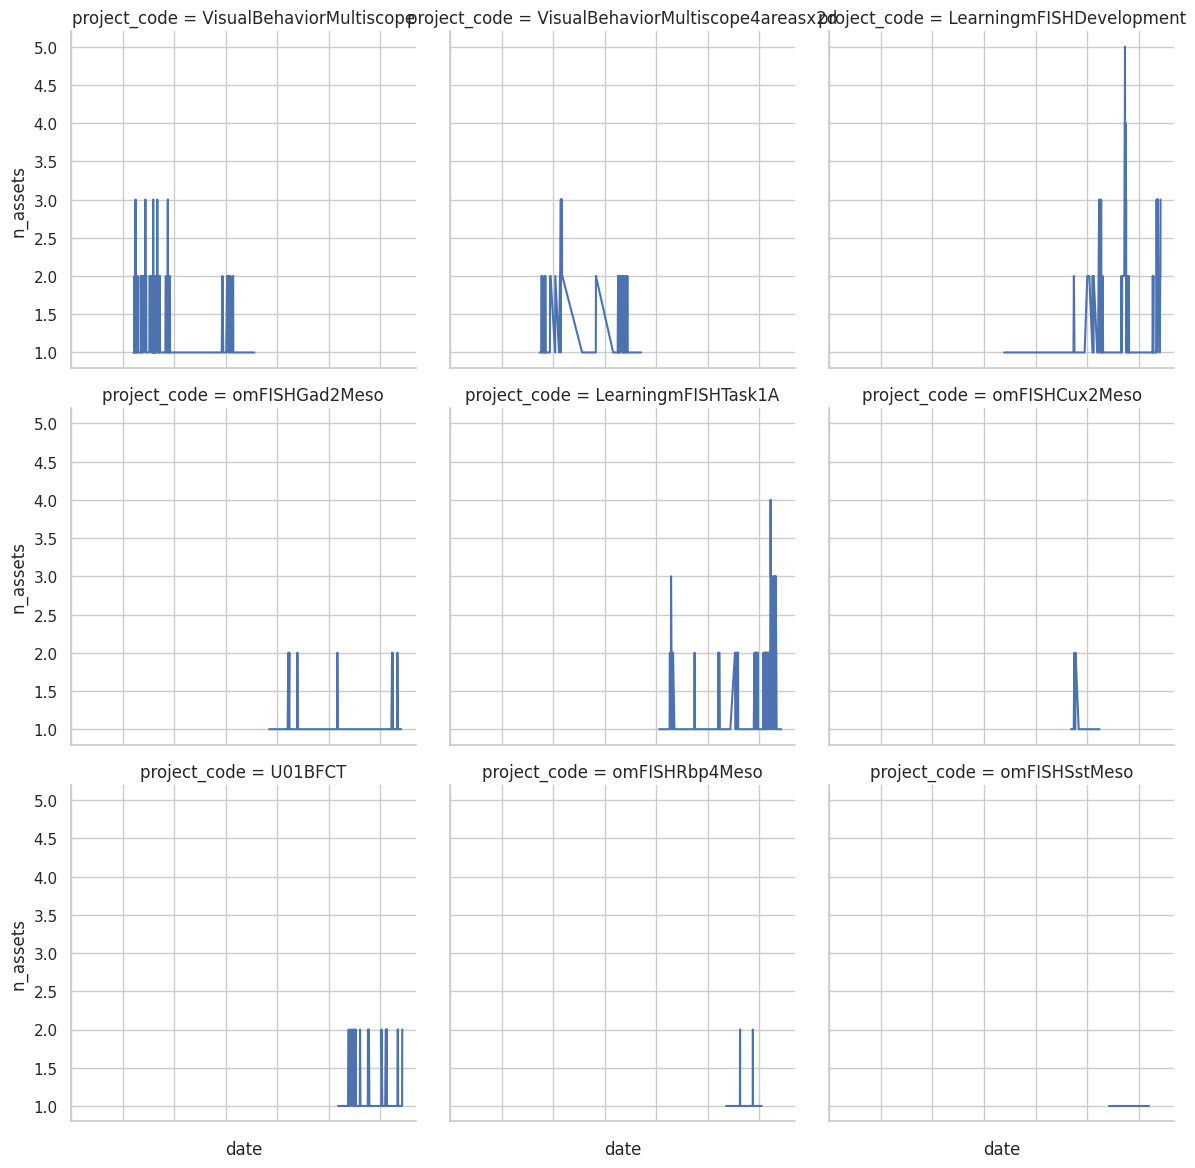

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn, lineplot, x=date, y=number of assets, facet by project_code
sns.set_theme(style="whitegrid")

# calc counts by date
date_counts = lims_co_table.groupby(['date', 'project_code']).size().reset_index(name='n_assets')
date_counts

# plot
g = sns.FacetGrid(date_counts, col="project_code", col_wrap=3, height=4, aspect=1)
g.map(sns.lineplot, "date", "n_assets")
g.set_xticklabels(rotation=45)
plt.show()

# Plots

In [42]:
project_code_count

,on_code_ocean,lims_count,percent,not_uploaded
project_code,,,,
VisualBehaviorMultiscope4areasx2d,99,186,0.532258,87
LearningmFISHDevelopment,64,242,0.264463,178
LearningmFISHTask1A,77,486,0.158436,409
VisualBehaviorMultiscope,26,302,0.086093,276
omFISHGad2Meso,5,113,0.044248,108
U01BFCT,4,128,0.031250,124


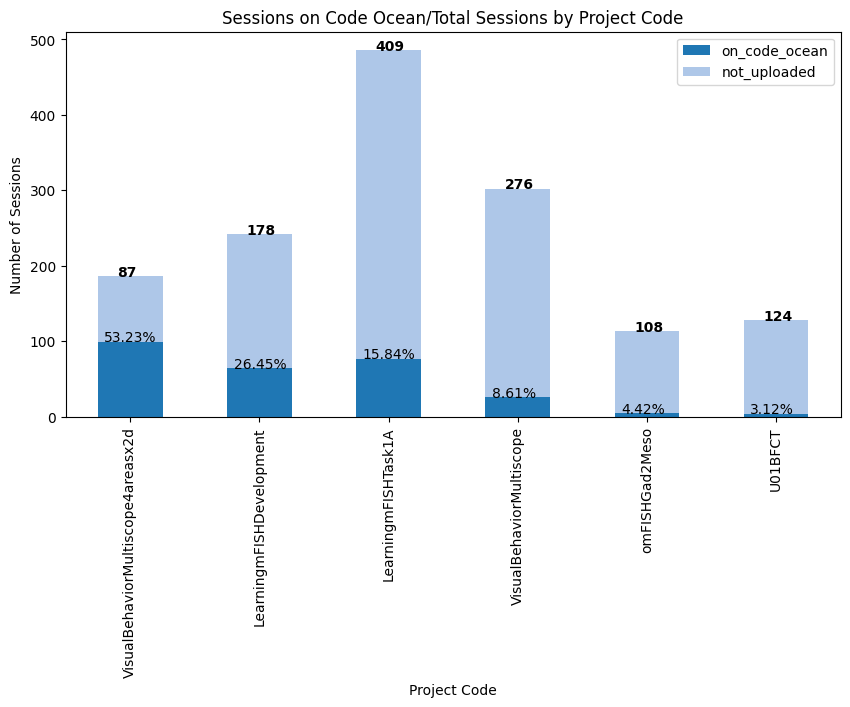

In [53]:
# get count of project codes in merge_df and session_table and combine
project_code_count = merge_df['project_code'].value_counts()
project_code_count = project_code_count.reset_index()
project_code_count.columns = ['project_code', 'on_code_ocean']
project_code_count = project_code_count.set_index('project_code')
project_code_count = project_code_count.join(session_table['project_code'].value_counts())
project_code_count = project_code_count.rename(columns={'project_code':'lims_count'})
project_code_count = project_code_count.fillna(0)
project_code_count = project_code_count.astype(int)
# calc percent
project_code_count['percent'] = project_code_count['on_code_ocean'] / project_code_count['lims_count']
# calc lims - asset count
project_code_count['not_uploaded'] = project_code_count['lims_count'] - project_code_count['on_code_ocean']
project_code_count = project_code_count.sort_values(by='percent', ascending=False)

# plot stacked bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
# plot stacked bar chart, lims_count = total number of sessions in lims, on_code_ocean = number of assets in code ocean
# make pretty colors for two bars, blues
colors = ['#1f77b4', '#aec7e8']
project_code_count[['on_code_ocean','not_uploaded']].plot(kind='bar', stacked=True, ax=ax, color=colors)

# add project_code_count['percent'] to bottom of bar, and 'not_uploaded' to top of bar
for i, v in enumerate(project_code_count['percent']):
    ax.text(i-0.2, v + project_code_count['on_code_ocean'][i], str(round(v*100, 2))+'%', color='black')
    ax.text(i-.1, v + project_code_count['lims_count'][i], str(project_code_count['not_uploaded'][i]), color='black', fontweight='bold')

# ylim n sessions
# xlim project_code
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Project Code')
ax.set_title('Sessions on Code Ocean/Total Sessions by Project Code')


plt.show()


## key processed

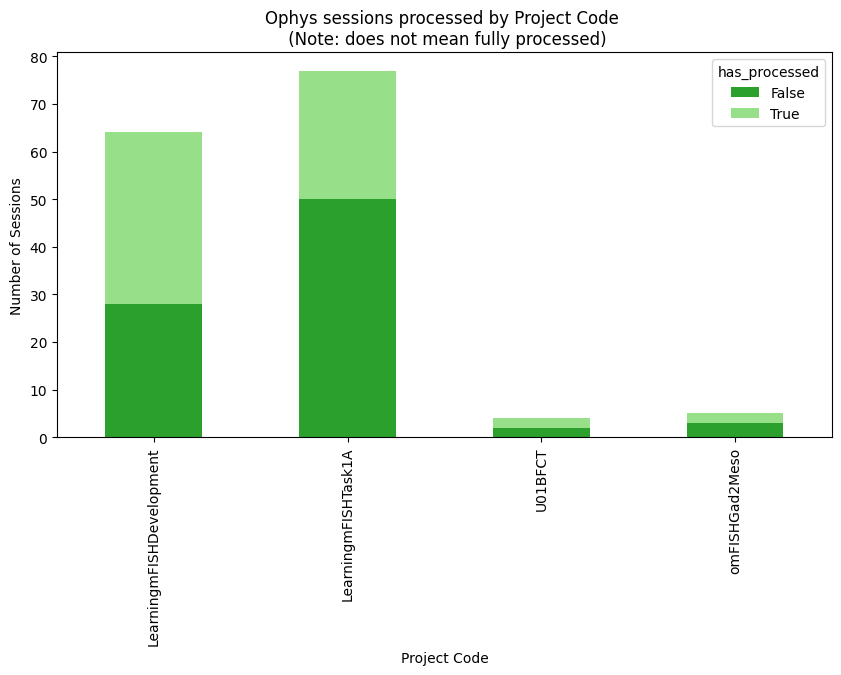

In [189]:
# drop VisualBehaviorMultiscope4areasx2d,VisualBehaviorMultiscope
processed_df = final_df[~final_df['project_code'].isin(['VisualBehaviorMultiscope4areasx2d','VisualBehaviorMultiscope'])].copy()
processed_df.project_code.value_counts()

# if processed_name notnan add new col has_processed = True, prevent set copy warning
processed_df['has_processed'] = processed_df['processed_name'].notna()

# make stacked count plot of has_processed by project_code
fig, ax = plt.subplots(figsize=(10,5))
# make pretty colors for two bars, greens
colors = ['#2ca02c', '#98df8a']
processed_df.groupby(['project_code','has_processed']).size().unstack().plot(kind='bar', stacked=True, ax=ax, color=colors)

ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Project Code')
ax.set_title('Ophys sessions processed by Project Code \n (Note: does not mean fully processed)')


plt.show()

# Pipeline versions

In [113]:
# do count of pipeline
processed_df['pipeline'].value_counts()


pipeline-v3.0    53
Name: pipeline, dtype: int64

# Individual mice

In [10]:
# , vip-cre, VBM NOTE: this mouse has duplicate sessions uploaded
mouse_id = '563231'

# lamf + omfish, gad2-cre
mouse_id = '677594' # lead mouse
mouse_id = '681417' # tin mouse

def mouse_sessions(mouse_id, df):
    # get all sessions for mouse_id
    mouse_sessions = df[merge_df['mouse_id'] == mouse_id]
    mouse_sessions = mouse_sessions.sort_values(by='date_str')

    return mouse_sessions

mouse_df = mouse_sessions(mouse_id, merge_df).reset_index(drop=True)
print(mouse_df[['id','name']].to_csv())

,id,name
0,89421805-ed71-487a-aac7-917cb9c1f899,multiplane-ophys_681417_2023-07-12_10-06-22
1,8aa984c6-9fc5-465c-9bc7-373a232c8283,multiplane-ophys_681417_2023-07-13_10-10-43
2,2a96c6c6-2f52-4f76-a18b-c3855be28874,multiplane-ophys_681417_2023-07-14_10-05-10
3,00e71d71-0a88-4ecd-ba81-6df542d120c0,multiplane-ophys_681417_2023-07-14_10-05-10
4,24876419-b80f-4ae2-9772-2be0c554e6c7,multiplane-ophys_681417_2023-07-17_10-17-38
5,74de10a8-bc4a-4422-91de-ae496b0739fe,multiplane-ophys_681417_2023-07-17_10-17-38
6,02d3dedf-5722-438b-82cf-f957a0e9b220,multiplane-ophys_681417_2023-07-18_10-56-26
7,977de373-b163-4567-b17d-1f7141c7d502,multiplane-ophys_681417_2023-07-18_10-56-26
8,833a6494-1a9f-4ac1-835e-841caad8dd74,multiplane-ophys_681417_2023-07-18_10-56-26
9,cf251b85-2444-4180-97b8-637629213494,multiplane-ophys_681417_2023-07-19_10-33-35
10,d80e7895-cbc6-46b6-9cf9-22a3ac75ae0f,multiplane-ophys_681417_2023-07-20_09-59-08
11,ab53c592-dbdb-40a8-95a4-54b64dbebcea,multiplane-ophys_681417_2023-07-24_09

In [11]:
mouse_df

,id,name,session_path,ophys_path,platform_json_path,lims_osid,ophys_session_id,mouse_id,specimen_id,date_str,session_type,equipment_name,project_code
0,89421805-ed71-487a-aac7-917cb9c1f899,multiplane-ophys_681417_2023-07-12_10-06-22,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282480118,1.282480e+09,681417,1.274325e+09,2023-07-12,TRAINING_0_gratings_autorewards_15min,MESO.2,LearningmFISHTask1A
1,8aa984c6-9fc5-465c-9bc7-373a232c8283,multiplane-ophys_681417_2023-07-13_10-10-43,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282665200,1.282665e+09,681417,1.274325e+09,2023-07-13,TRAINING_1_gratings,MESO.2,LearningmFISHTask1A
2,2a96c6c6-2f52-4f76-a18b-c3855be28874,multiplane-ophys_681417_2023-07-14_10-05-10,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282892466,1.282892e+09,681417,1.274325e+09,2023-07-14,TRAINING_1_gratings,MESO.2,LearningmFISHTask1A
3,00e71d71-0a88-4ecd-ba81-6df542d120c0,multiplane-ophys_681417_2023-07-14_10-05-10,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1282892466,1.282892e+09,681417,1.274325e+09,2023-07-14,TRAINING_1_gratings,MESO.2,LearningmFISHTask1A
4,24876419-b80f-4ae2-9772-2be0c554e6c7,multiplane-ophys_681417_2023-07-17_10-17-38,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283445129,1.283445e+09,681417,1.274325e+09,2023-07-17,TRAINING_2_gratings_flashed,MESO.2,LearningmFISHTask1A
5,74de10a8-bc4a-4422-91de-ae496b0739fe,multiplane-ophys_681417_2023-07-17_10-17-38,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283445129,1.283445e+09,681417,1.274325e+09,2023-07-17,TRAINING_2_gratings_flashed,MESO.2,LearningmFISHTask1A
6,02d3dedf-5722-438b-82cf-f957a0e9b220,multiplane-ophys_681417_2023-07-18_10-56-26,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283799929,1.283800e+09,681417,1.274325e+09,2023-07-18,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A
7,977de373-b163-4567-b17d-1f7141c7d502,multiplane-ophys_681417_2023-07-18_10-56-26,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283799929,1.283800e+09,681417,1.274325e+09,2023-07-18,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A
8,833a6494-1a9f-4ac1-835e-841caad8dd74,multiplane-ophys_681417_2023-07-18_10-56-26,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1283799929,1.283800e+09,681417,1.274325e+09,2023-07-18,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A
9,cf251b85-2444-4180-97b8-637629213494,multiplane-ophys_681417_2023-07-19_10-33-35,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,/mnt/aind-ophys-data/multiplane-ophys_681417_2...,1284023946,1.284024e+09,681417,1.274325e+09,2023-07-19,TRAINING_3_images_A_10uL_reward,MESO.2,LearningmFISHTask1A


In [66]:
# groupby mouse_id
# get just VisualBehaviorMultiscope4areasx2d

vb = merge_df[merge_df['project_code'] == 'VisualBehaviorMultiscope4areasx2d']
vb['mouse_id'].value_counts()

481295    19
554115    18
513630    18
563234    17
563231    17
524158    17
561443    17
484408    16
472271    16
484631    15
550603    15
555970    15
489065    15
485689    14
477052    13
499478     9
570949     7
Name: mouse_id, dtype: int64

In [74]:
vb = merge_df[merge_df['project_code'] == 'LearningmFISHTask1A']
vb['mouse_id'].value_counts()

677594    22
711414    21
681417    21
671833     5
612764     3
636496     3
704576     2
639224     2
721291     1
629294     1
603892     1
Name: mouse_id, dtype: int64

# Processed

In [8]:
code = CodeOceanDataExplorer(query='multiplane')
da = code.derived_assets

print(len(da))

CodeOceanDataExplorer initialized
---------------------------------
Query: multiplane
Number of assets: 659
112


In [9]:
da

[{'created': 1711059896,
  'description': '',
  'files': 1,
  'id': '3efbe817-5a8c-43fe-b328-feea61aa78ad',
  'last_used': 1711059898,
  'mount': 'multiplane-ophys_485152_2019-12-09_13-04-09_dlc-eye_2024-03-15_21-19-18',
  'name': 'multiplane-ophys_485152_2019-12-09_13-04-09_dlc-eye_2024-03-15_21-19-18',
  'provenance': {'capsule': '4cf0be83-2245-4bb1-a55c-a78201b14bfe',
   'commit': '4bf92b004f2e37a2d8496b43f79d28dfdca5b062',
   'data_assets': ['05529cfc-23fe-4ead-9490-71763e9f7c01',
    'c65a4625-8b3b-4d3a-b300-a6f659cbcc3b'],
   'docker_image': 'cb357fec-be48-4122-b016-b71fb9f1a8ba',
   'run_script': 'code/run'},
  'size': 2066403,
  'state': 'ready',
  'tags': ['derived', 'dlc-eye', 'ophys-mfish'],
  'type': 'result'},
 {'created': 1716095556,
  'custom_metadata': {'data level': 'derived',
   'experiment type': 'multiplane-ophys',
   'subject id': '724567'},
  'description': '',
  'files': 31,
  'id': '8e58cac0-61e4-43a6-a6ea-c866352afa71',
  'last_used': 1716095745,
  'mount': 'mu